<a href="https://colab.research.google.com/github/cheongyeechian/DLI/blob/main/Group_Gan_Sze_Qing_TP073672.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
# =============================== Setup ===============================
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_curve, auc
import time
import random
import joblib

# Fix random seed for reproducibility
np.random.seed(42)
random.seed(42)

# File path
csv_path = '/content/drive/My Drive/Colab Notebooks/dataset.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# =============================== Data Loading ===============================
df = pd.read_csv(csv_path)
print("===== Original Dataset (first 5 rows) =====")
display(df.head())
print("=========================================")

===== Original Dataset (first 5 rows) =====


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [57]:
# =============================== Pre-processing ===============================
TARGET = "status"

# Drop duplicates
df = df.drop_duplicates().reset_index(drop=True)

# Extract label and normalize
y = df[TARGET].astype(str).str.strip().str.lower().map({
    "phishing": 1,
    "legitimate": 0,
    "1": 1,
    "0": 0
})

# Remove invalid labels
mask = ~y.isna()
df, y = df.loc[mask].reset_index(drop=True), y.loc[mask].astype(int).reset_index(drop=True)

# Drop target column
df = df.drop(columns=[TARGET])

# Encode non-numeric features (url + others)
for c in df.select_dtypes(include=["object","bool"]).columns:
    df[c] = df[c].astype("category").cat.codes.replace(-1, 0)

# Ensure numeric & fill NaN
df = df.apply(pd.to_numeric, errors="coerce").fillna(0)

# Features
features = df.values.astype(float)

# Print transformed dataset
print("===== Transformed Dataset (first 5 rows) =====")
display(pd.DataFrame(features, columns=df.columns).head())
print("=========================================")

# Class balance info
n_pos, n_neg = int((y == 1).sum()), int((y == 0).sum())
print(f"[INFO] Class balance -> phishing: {n_pos:,}, legitimate: {n_neg:,}, total: {len(y):,}")
print(f"[INFO] Positive ratio: {n_pos/len(y):.4f}")

===== Transformed Dataset (first 5 rows) =====


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,empty_title,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank
0,4501.0,37.0,19.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,45.0,-1.0,0.0,1.0,1.0,4.0
1,3063.0,77.0,23.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,77.0,5767.0,0.0,0.0,1.0,2.0
2,8984.0,126.0,50.0,1.0,4.0,1.0,0.0,1.0,2.0,0.0,...,0.0,1.0,0.0,0.0,14.0,4004.0,5828815.0,0.0,1.0,0.0
3,2778.0,18.0,11.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,62.0,-1.0,107721.0,0.0,0.0,3.0
4,5261.0,55.0,15.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,224.0,8175.0,8725.0,0.0,0.0,6.0


[INFO] Class balance -> phishing: 5,715, legitimate: 5,715, total: 11,430
[INFO] Positive ratio: 0.5000


In [58]:
# =============================== Train-Test Split ===============================
split_index = int(len(features) * 0.9)
features_train = features[:split_index]
features_test = features[split_index:]
labels_train = y[:split_index]
labels_test = y[split_index:]

# Standardize features
scaler = StandardScaler()
features_train = scaler.fit_transform(features_train)
features_test = scaler.transform(features_test)

In [59]:
# =============================== Model Training ===============================
clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
clf.fit(features_train, labels_train)
predictions = clf.predict(features_test)


===== Nearest Neighbors Algorithm Results =====

Accuracy: 0.9413823272090989
Precision: 0.9613259668508287
Recall: 0.9190140845070423
F1 Score: 0.9396939693969397
Confusion Matrix:
 [[554  21]
 [ 46 522]]


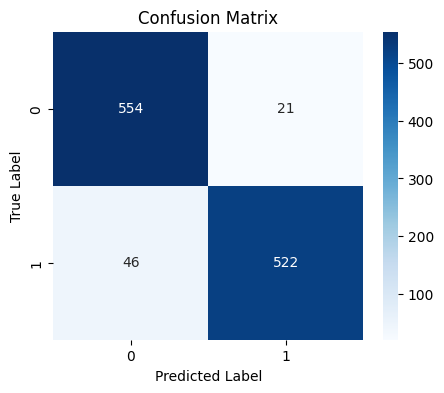

In [60]:
# =============================== Evaluation ===============================
# Metrics
accuracy = accuracy_score(labels_test, predictions)
precision = precision_score(labels_test, predictions)
recall = recall_score(labels_test, predictions)
f1 = f1_score(labels_test, predictions)
conf_matrix = confusion_matrix(labels_test, predictions)

print("\n===== Nearest Neighbors Algorithm Results =====\n")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)

# Confusion matrix heatmap
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()




In [61]:
# =============================== Save Model ===============================
model_path = '/content/drive/My Drive/Colab Notebooks/knn_model.pkl'
joblib.dump(clf, model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/My Drive/Colab Notebooks/knn_model.pkl
